In [295]:
#pip install cvxopt
#pip install cvxpy
#pip install PyPortfolioOpt

#conda install cvxopt
#conda install cvxpy
#conda install PyPortfolioOpt

"""
해당 파일은 python 3.7.15 버전에서 작성되었습니다.
일부 라이브러리의 버전 차이로 인해 실행이 되지 않을 수 있습니다.
설치가 되지 않는다면 pip install cvxopt, pip install cvxpy 먼저 실행 부탁드립니다.
"""

'\n해당 파일은 python 3.7.15 버전에서 작성되었습니다.\n일부 라이브러리의 버전 차이로 인해 실행이 되지 않을 수 있습니다.\n설치가 되지 않는다면 pip install cvxopt, pip install cvxpy 먼저 실행 부탁드립니다.\n'

In [296]:
import gc
gc.collect(generation=2)

44101

In [297]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pmdarima as pm
import math
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from news_function_all import * # 미리 정의해놓은 함수 import

In [298]:
# 포트폴리오 관련 library import

import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers
from pypfopt.efficient_frontier import EfficientFrontier # 정확하게는 모르겠는데 3.7은 사용가능
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [299]:
df = pd.read_csv("C:/Users/User/github/Web_crawling/save_data/stock_data.csv", encoding='cp949')
score = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/total_rate.csv", encoding='cp949')

In [300]:
kospi = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/kospi_200.csv",encoding='cp949')

In [301]:
time = pd.date_range('2019-01-01','2023-01-01', freq='m')
kospi=kospi.sort_values('연월')
kospi['time'] = time
kospi.set_index('time', inplace=True)
kospi.drop('연월',axis=1, inplace=True)
kospi = kospi[['종가', '대비']]
kospi['kospi'] = kospi['대비']/kospi['종가']

In [302]:
market_price = 1000000
kospi_result = []
kkk_result = []

for i in range(0, len(kospi)):
    kkk = kospi.iloc[i,2] * market_price # 순수익
    kospi_price = market_price + kkk # 현재 내 재산 
    kospi_result.append(kospi_price)  # 내재산은 저장하고 // 다시 돌려줘
    market_price = kospi_price
    kkk_result.append(kkk) 

In [303]:
df.set_index('time', inplace=True)
#df['time'] = pd.DatetimeIndex(df['time'])

In [304]:
# train 데이터와 validation 데이터 나누기.
X_train = df[(df.index < '2019-01-01') & (df.index > "2014.01.01")]
X_valid = df[df.index >= '2019-01-01']

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train Shape (48, 21)
X_Valid Shape (48, 21)


---
#### train 구간만 사용한 포트폴리오와 예측 구간까지 사용한 포트폴리오의 차이를 확인할 것입니다.
#### train 구간이 움직일때 포트폴리오를 다시 최적화를 진행합니다.
#### 즉 한달 주기로 포트폴리오를 다시 구성하는 것입니다.
#### 수수료는 없다고 가정합니다.
#### 처음 주식을 구매하고 주식을 전부 판매하고 다시 주식을 구매하는 것으로 돈을 계속 계산하게 됩니다.

#### 간단한 예시본 후에 최종적인 코드 보면 이해에 도움이 됩니다.

In [305]:
weights = np.ones(21) # 초기에 가중치를 1로 설정
weights = weights/21 # 이후 동일하게 1/22으로 나눠서 설정 (가중치 합은 항상 1)

returns=X_train.pct_change() # 단순 수익률 계산 => (다음날 값 +- 기준일 값)/기준일 값 으로 수익률 나옵니다.

cov_matrix_annual=returns.cov()*12 # 데이터 기준이 DAY가 아니라 MONTH이므로 12를 곱해 연간 수익률로 계산

port_variance= weights.T @ cov_matrix_annual @ weights # 포트폴리오 분산의 기대값 = WT * (공분산{= 시그마}) * W를 코드로 옆처럼 나타냄

port_volatility=np.sqrt(port_variance) # 포트폴리오 변동성의 기대값 = SQRT(WT * 공분산(=시그마) * W) // 그냥 표준편차 = 변동성

portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*12 # 연간 수익률 계산 DAY가 아니라 MONTH기준이므로 12곱하면 됨

In [306]:
percent_var=str(round(port_variance,2)*100)+'%' # 연간 예상 분산
percent_vol=str(round(port_volatility,2)*100)+'%' # 연간 예상 변동성
percent_ret=str(round(portfolioSimpleAnnualReturn,2)*100)+'%' # 연간 예상 수익률

print('Expected Annual Return :'+ percent_ret )
print('Annual Volatility/risk :'+ percent_vol )
print('Annual Variance :'+ percent_var )

Expected Annual Return :2.0%
Annual Volatility/risk :13.0%
Annual Variance :2.0%


In [307]:
market_price = 1000000
market_solution = []
market_money = []
market_sol = pd.DataFrame(index=range(0,1), columns = df.columns)
market_profit = []
market_weights = np.ones(21)/21 # 초기에 가중치를 1로 설정
market_weights = dict(zip(list(df.columns),list(market_weights)))

for i in range(0,len(X_valid)):
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(market_weights, test_table, total_portfolio_value = market_price)

    data_2,solution_2 = da.lp_portfolio() 
    market_mat = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    market_sol = pd.merge(market_sol, market_mat, how = 'outer').fillna(0)
    market_solution = (market_sol.iloc[-1,:] @ X_valid.iloc[i,:].T) - market_price        
    market_price += market_solution 
    market_money.append(market_price)
    market_profit.append(market_solution)

In [308]:
1000000*market_price / X_train.iloc[-1,:] @ X_valid.iloc[-1,:] # 실제로 위의 포트폴리오를 구성했을 때의 수익

20753440494675.312

In [309]:
# Portfolio optimization

# Calculate the expexted returns and annualised sample covariance matrix of the asset returns
mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준

# Optimize the max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
#weights = ef.max_sharpe()
#weights = ef.max_quadratic_utility() 

cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

latest_prices = get_latest_prices(X_train)
weights = cleaned_weights 

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000000000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation:", allocation) # 해당주를 얼마나 구입하는가
print("Funds remaining: ${:.2f}".format(leftover)) # 예상 수익

OrderedDict([('음식료품', 0.27415), ('섬유의복', 0.05202), ('종이목재', 0.0), ('화학', 0.0), ('의약품', 0.0), ('비금속광물', 0.0), ('철강금속', 0.0), ('기계', 0.0), ('전기전자', 0.22073), ('의료정밀', 0.00626), ('운수장비', 0.0), ('유통업', 0.0), ('전기가스업', 0.1168), ('건설업', 0.0), ('운수창고업', 0.00168), ('통신업', 0.13646), ('금융업', 0.0), ('은행', 0.10348), ('증권', 0.0), ('보험', 0.08841), ('서비스업', 0.0)])
Expected annual return: 0.3%
Annual volatility: 9.3%
Sharpe Ratio: -0.18
Discrete allocation: {'음식료품': 69229624, '섬유의복': 205199006, '전기전자': 15278584, '의료정밀': 2933679, '전기가스업': 111174567, '운수창고업': 1252526, '통신업': 342872937, '은행': 344233392, '보험': 5422832}
Funds remaining: $9982863.89


In [310]:
l = pd.DataFrame(index=range(0,1), columns = df.columns)
l_2 = pd.merge(l, pd.DataFrame.from_dict(data = allocation, orient='index', dtype='int').T, how = 'outer').fillna(0)
l_2.iloc[1,:]@X_valid.iloc[-1,:].T # 포트폴리오 실제 수익

981168152427.3

### Moving window

----
### 뉴스 정보와 결합

In [311]:
score_df = score[['음식료품_positive_rate','섬유의복_positive_rate','종이목재_positive_rate','화학_positive_rate','의약품_positive_rate','비금속광물_positive_rate','철강금속_positive_rate','기계_positive_rate','전기전자_positive_rate','의료정밀_positive_rate','운수장비_positive_rate','유통업_positive_rate','전기가스업_positive_rate','건설업_positive_rate','운수창고_positive_rate','통신업_positive_rate','금융업_positive_rate','은행_positive_rate','증권_positive_rate','보험_positive_rate','서비스업_positive_rate']]
score_df.columns = df.columns
score_df = score_df.fillna(int(0))
score_df['time'] = pd.date_range('2013-01-01','2022-12-31',freq='m')
score_df['time'] = score_df['time'].astype(str)
score_df.set_index('time', inplace=True) 
#score_df = score_df.set_index(pd.date_range('2013-01-01','2022-12-31',freq='m'))

In [312]:
plot_time = pd.date_range('2019-01-01','2022-12-31',freq='m')

---
## 최소분산 포트폴리오

In [313]:
a = 1000000
solution = []
money = []
profit = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
weight_check_minviolatility = []

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)

    weights = ef.min_volatility()    
    #weights = ef.max_quadratic_utility()      
    #weights = ef.max_sharpe()    
    
    cleaned_weights = ef.clean_weights()
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    j = np.where(score_df.index == check)

    finish_weight_2 = weight_cal(list(cleaned_weights.values()),score_df.iloc[j[0][0],:] )
    finish_weight_2.index = df.columns
    weight_check_minviolatility.append(finish_weight_2)
    da = DiscreteAllocation(OrderedDict(finish_weight_2), test_table, total_portfolio_value = a)

    data,solution = da.lp_portfolio()
    #money.append(a)
    mat = pd.DataFrame.from_dict(data = data, orient='index', dtype='int').T
    sol = pd.merge(sol, mat, how = 'outer').fillna(0)
    solution = sol.iloc[-1,:] @ X_valid.iloc[i,:].T - a
    a += solution
    money.append(a)
    profit.append(solution)




In [314]:
b = 1000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
profit_2 = []

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:  
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)

    # table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
    # mu = expected_returns.mean_historical_return(table, frequency = 12)
    # S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)
    weights_2 = ef.min_volatility()    
    #weights_2 = ef.max_quadratic_utility()
    #weights_2 = ef.max_sharpe()      
    cleaned_weights = ef.clean_weights() 
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = b)

    data_2,solution_2 = da.lp_portfolio() 
    #money_2.append(b)
    mat_2 = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    sol_2 = pd.merge(sol_2, mat_2, how = 'outer').fillna(0)
    solution_2 = (sol_2.iloc[-1,:] @ X_valid.iloc[i,:].T) - b        
    #solution_2 = solution_2 - b   
    b += solution_2 
    money_2.append(b)
    profit_2.append(solution_2)

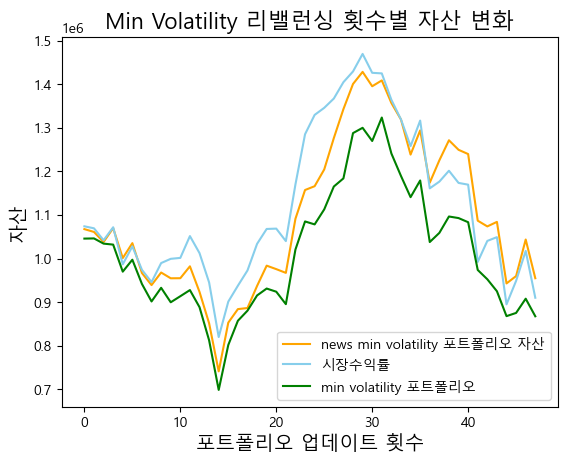

In [315]:
plt.plot(money, label = 'news min volatility 포트폴리오 자산', color = 'orange')
plt.plot(kospi_result, label = '시장수익률', color = 'skyblue')
plt.plot(money_2, label = 'min volatility 포트폴리오', color = 'green')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('자산', size = 14)
plt.title('Min Volatility 리밸런싱 횟수별 자산 변화', size = 16)
plt.legend()
plt.show()

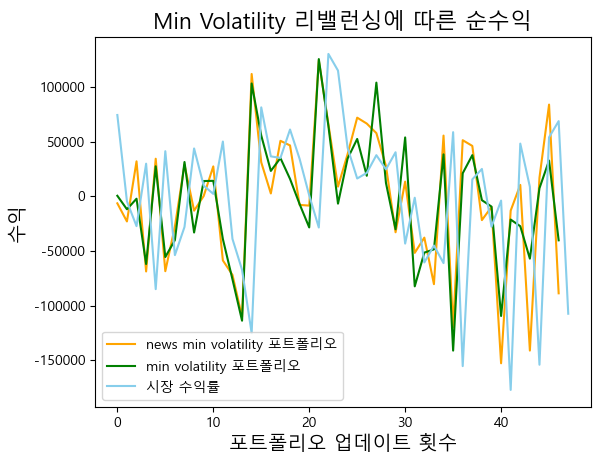

In [316]:
plt.title('Min Volatility 리밸런싱에 따른 순수익', size = 16)
plt.plot(profit[1:], label = 'news min volatility 포트폴리오', color = 'orange')
plt.plot(profit_2[1:], label = 'min volatility 포트폴리오',color = 'green')
plt.plot(kkk_result, label = '시장 수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('수익', size = 14)
plt.legend()
plt.show()

---
## Max Quadratic 포트폴리오

In [317]:
a = 1000000
solution = []
money = []
profit = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
weight_check_maxquadratic = []

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)

    #weights = ef.min_volatility()    
    weights = ef.max_quadratic_utility(risk_aversion=0.8)      
    #weights = ef.max_sharpe()    
    
    cleaned_weights = ef.clean_weights()
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    j = np.where(score_df.index == check)

    finish_weight_2 = weight_cal(list(cleaned_weights.values()),score_df.iloc[j[0][0],:] )
    finish_weight_2.index = df.columns
    weight_check_maxquadratic.append(finish_weight_2)
    
    da = DiscreteAllocation(OrderedDict(finish_weight_2), test_table, total_portfolio_value = a)

    data,solution = da.lp_portfolio()
    #money.append(a)
    mat = pd.DataFrame.from_dict(data = data, orient='index', dtype='int').T
    sol = pd.merge(sol, mat, how = 'outer').fillna(0)
    solution = sol.iloc[-1,:] @ X_valid.iloc[i,:].T - a
    a += solution
    money.append(a)
    profit.append(solution)




In [318]:
b = 1000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
profit_2 = []

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:  
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)

    # table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
    # mu = expected_returns.mean_historical_return(table, frequency = 12)
    # S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)
    #weights_2 = ef.min_volatility()    
    weights_2 = ef.max_quadratic_utility(risk_aversion=0.8)
    #weights_2 = ef.max_sharpe()      
    cleaned_weights = ef.clean_weights() 
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = b)

    data_2,solution_2 = da.lp_portfolio() 
    #money_2.append(b)
    mat_2 = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    sol_2 = pd.merge(sol_2, mat_2, how = 'outer').fillna(0)
    solution_2 = (sol_2.iloc[-1,:] @ X_valid.iloc[i,:].T) - b        
    #solution_2 = solution_2 - b   
    b += solution_2 
    money_2.append(b)
    profit_2.append(solution_2)

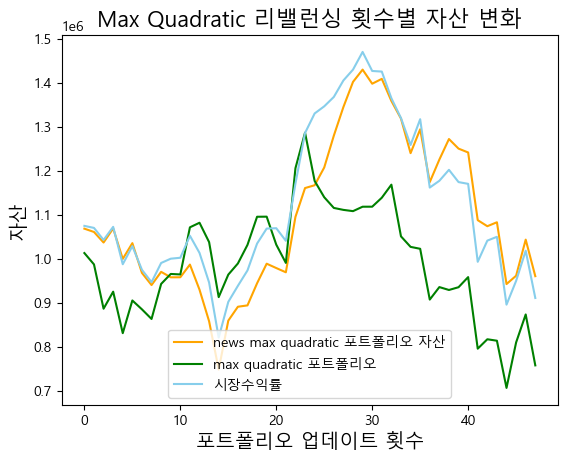

In [319]:
plt.plot(money, label = 'news max quadratic 포트폴리오 자산', color = 'orange')
plt.plot(money_2, label = 'max quadratic 포트폴리오', color = 'green')
plt.plot(kospi_result, label = '시장수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('자산', size = 14)
plt.title('Max Quadratic 리밸런싱 횟수별 자산 변화', size = 16)
plt.legend()
plt.show()

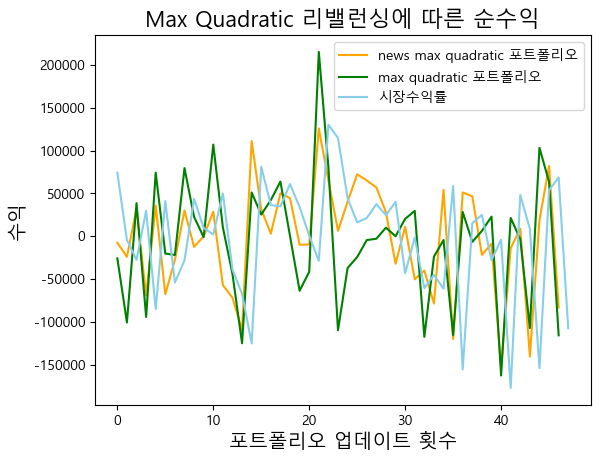

In [320]:
plt.title('Max Quadratic 리밸런싱에 따른 순수익', size = 16)
plt.plot(profit[1:], label = 'news max quadratic 포트폴리오', color = 'orange')
plt.plot(profit_2[1:], label = 'max quadratic 포트폴리오',color = 'green')
plt.plot(kkk_result, label = '시장수익률',color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('수익', size = 14)
plt.legend()
plt.show()

---
## Max sharpe 포트폴리오 비교

In [321]:
a = 1000000
solution = []
money = []
profit = []
sol = pd.DataFrame(index=range(0,1), columns = df.columns)
weight_check_maxsharpe = []

for i in range(0,len(X_valid)):
    check = str(pd.date_range('2019-01-01','2022-12-31',freq='m')[i])[0:10]
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)

    #weights = ef.min_volatility()    
    #weights = ef.max_quadratic_utility()      
    weights = ef.max_sharpe(risk_free_rate=0.05)    
    
    cleaned_weights = ef.clean_weights()
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    j = np.where(score_df.index == check)

    finish_weight_2 = weight_cal(list(cleaned_weights.values()),score_df.iloc[j[0][0],:] )
    finish_weight_2.index = df.columns
    weight_check_maxsharpe.append(finish_weight_2)
    da = DiscreteAllocation(OrderedDict(finish_weight_2), test_table, total_portfolio_value = a)

    data,solution = da.lp_portfolio()
    #money.append(a)
    mat = pd.DataFrame.from_dict(data = data, orient='index', dtype='int').T
    sol = pd.merge(sol, mat, how = 'outer').fillna(0)
    solution = sol.iloc[-1,:] @ X_valid.iloc[i,:].T - a
    a += solution
    money.append(a)
    profit.append(solution)




In [322]:
b = 1000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
profit_2 = []

for i in range(0,len(X_valid)):
    if i == 0:
        mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
        S = risk_models.sample_cov(X_train, frequency = 12)
    else:  
        table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]]) 
        mu = expected_returns.mean_historical_return(table, frequency = 12)
        S = risk_models.sample_cov(table, frequency = 12)

    # table = pd.concat([X_train.iloc[i:,:], X_valid.iloc[:i,:]])
    # mu = expected_returns.mean_historical_return(table, frequency = 12)
    # S = risk_models.sample_cov(table, frequency = 12)
    
    ef = EfficientFrontier(mu,S)
    #weights_2 = ef.min_volatility()    
    #weights_2 = ef.max_quadratic_utility()
    weights_2 = ef.max_sharpe(risk_free_rate=0.05)      
    cleaned_weights = ef.clean_weights() 
    if i == 0:
        test_table = get_latest_prices(X_train)
    else:     
        test_table = get_latest_prices(X_valid.iloc[:i,:])
    
    da = DiscreteAllocation(cleaned_weights, test_table, total_portfolio_value = b)

    data_2,solution_2 = da.lp_portfolio() 
    #money_2.append(b)
    mat_2 = pd.DataFrame.from_dict(data = data_2, orient='index', dtype='int').T
    sol_2 = pd.merge(sol_2, mat_2, how = 'outer').fillna(0)
    solution_2 = (sol_2.iloc[-1,:] @ X_valid.iloc[i,:].T) - b        
    #solution_2 = solution_2 - b   
    b += solution_2 
    money_2.append(b)
    profit_2.append(solution_2)

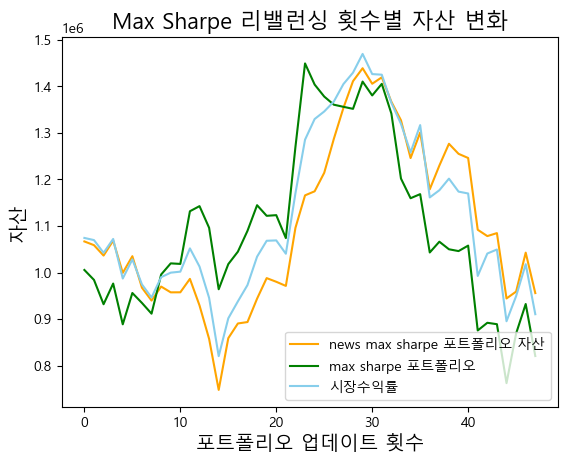

In [323]:
plt.plot(money, label = 'news max sharpe 포트폴리오 자산', color = 'orange')
plt.plot(money_2, label = 'max sharpe 포트폴리오', color = 'green')
plt.plot(kospi_result, label = '시장수익률', color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('자산', size = 14)
plt.title('Max Sharpe 리밸런싱 횟수별 자산 변화', size = 16)
plt.legend()
plt.show()

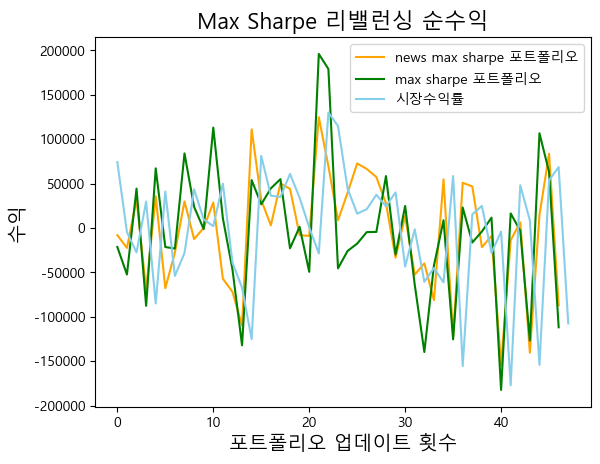

In [324]:
plt.title('Max Sharpe 리밸런싱 순수익', size = 16)
plt.plot(profit[1:], label = 'news max sharpe 포트폴리오', color = 'orange')
plt.plot(profit_2[1:], label = 'max sharpe 포트폴리오',color = 'green')
plt.plot(kkk_result, label = '시장수익률',color = 'skyblue')
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('수익', size = 14)
plt.legend()
plt.show()

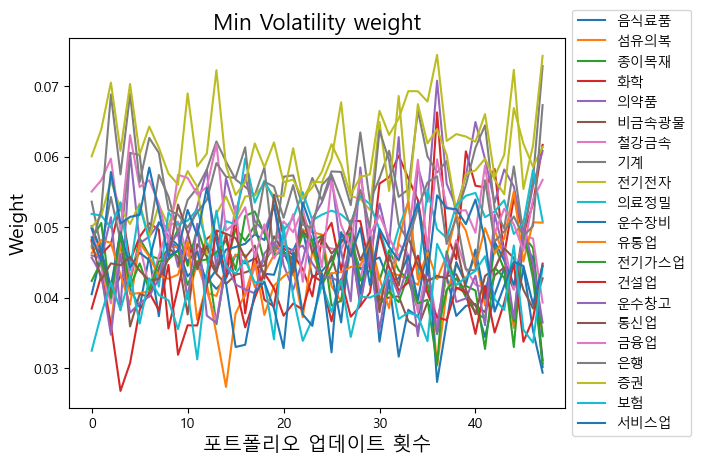

In [325]:
for i in range(0,len(df.columns)):
    plt.plot(pd.DataFrame(weight_check_minviolatility).iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.title('Min Volatility weight', size=16)
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('Weight', size = 14)
plt.show()

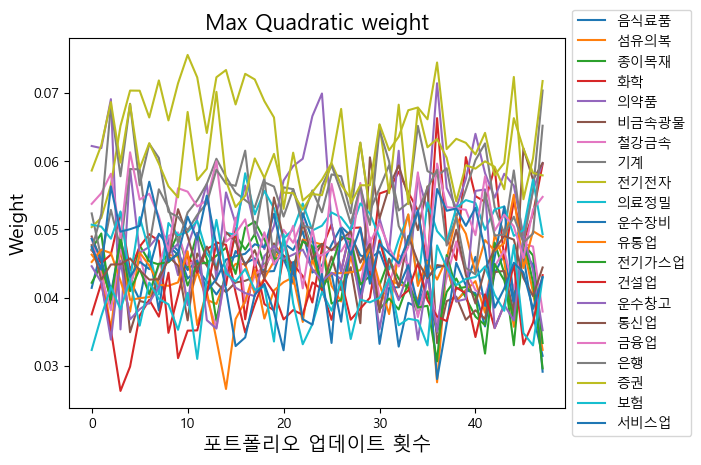

In [326]:
for i in range(0,len(df.columns)):
    plt.plot(pd.DataFrame(weight_check_maxquadratic).iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.title('Max Quadratic weight', size=16)
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('Weight', size = 14)
plt.show()

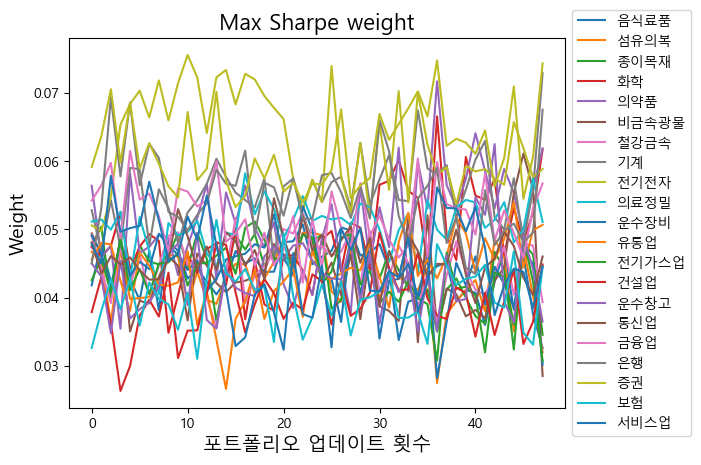

In [327]:
for i in range(0,len(df.columns)):
    plt.plot(pd.DataFrame(weight_check_maxsharpe).iloc[:,i], label = '{}'.format(category[i]))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.title('Max Sharpe weight', size=16)
plt.xlabel('포트폴리오 업데이트 횟수', size = 14)
plt.ylabel('Weight', size = 14)
plt.show()